In [8]:
import numpy as np
import LanczosCGApproximateGPs as gp
import matplotlib.pyplot as plt

### Sampling and basic definitions

In [35]:
sample_size = 100
noise_level = 0.1

X = np.array([np.linspace(-1, 1, sample_size)])
X = X.transpose()
eps = np.random.normal(0, noise_level, sample_size)
f = X[:, 0]**2
Y = f + eps

actions = []
index = 0
for iter in range(0, max_iter):
    action = np.zeros(sample_size)
    action[index] = 1
    actions.append(action)
    index = index + 1

We define standard kernel functions.

In [36]:
def brownian_kernel(x, y):
    z = np.minimum(x, y)
    return z

def gaussian_kernel(x, y):
    z = np.exp(-np.abs(x - y) / (200 * noise_level))
    return z

### Full eigenvector actions

In [37]:
kernel = gaussian_kernel
kernel_matrix = np.zeros((sample_size, sample_size)) 
for i in range(0, sample_size):
    for j in range(0, sample_size):
        kernel_matrix[i, j] = kernel(X[i, :], X[j, :])

U, S, Vh = np.linalg.svd(kernel_matrix, full_matrices = True)

number_of_eigenvectors = 50
eigenvector_actions = []
index = 0
for iter in range(0, number_of_eigenvectors):
    action = U[:, index]
    eigenvector_actions.append(action)
    index = index + 1

/tmp/ipykernel_354813/3774369156.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_matrix[i, j] = kernel(X[i, :], X[j, :])


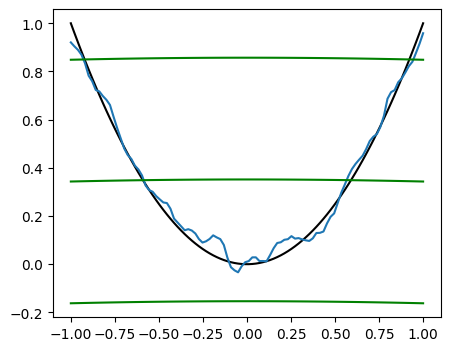

In [41]:
algorithm = gp.Iter_GP(X, Y, noise_level, eigenvector_actions, kernel = gaussian_kernel)
algorithm.iter_forward(1)

approx_posterior_mean = algorithm.approx_posterior_mean(X)
true_posterior_mean = algorithm.kernel_matrix @ np.linalg.inv(algorithm.augmented_kernel_matrix) @ Y

variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    variance_vector = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

upper_ci = approx_posterior_mean + 2 * np.sqrt(variance_vector)
lower_ci = approx_posterior_mean - 2 * np.sqrt(variance_vector)

fig = plt.figure(figsize = (5,4))
# plt.scatter(X[:, 0], Y)
plt.plot(X[:, 0], f, color = "black")
plt.plot(X[:, 0], true_posterior_mean)
plt.plot(X[:, 0], approx_posterior_mean, color = "green")
plt.plot(X[:, 0], upper_ci, color = "green")
plt.plot(X[:, 0], lower_ci, color = "green")

### Lanczos actions

In [65]:
kernel = gaussian_kernel
kernel_matrix = np.zeros((sample_size, sample_size)) 
for i in range(0, sample_size):
    for j in range(0, sample_size):
        kernel_matrix[i, j] = kernel(X[i, :], X[j, :])

number_of_eigenpairs = 4
starting_vector = Y / np.sqrt(np.sum(Y**2))
lanczos_alg = gp.Lanczos(kernel_matrix, starting_vector, number_of_eigenpairs)
lanczos_alg.run()
lanczos_alg.get_eigenquantities()

lanczos_actions = []
for index in range(number_of_eigenpairs):
    action = lanczos_alg.eigenvectors[:, index]
    lanczos_actions.append(action)

/tmp/ipykernel_354813/2969435651.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_matrix[i, j] = kernel(X[i, :], X[j, :])


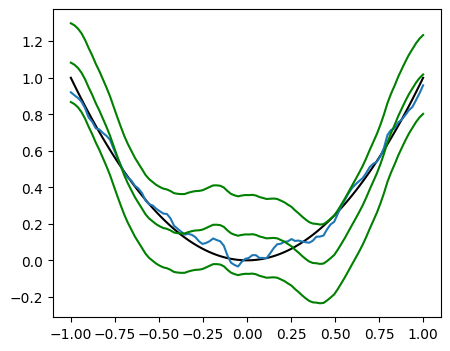

In [67]:
algorithm = gp.Iter_GP(X, Y, noise_level, lanczos_actions, kernel = gaussian_kernel)
algorithm.iter_forward(4)

approx_posterior_mean = algorithm.approx_posterior_mean(X)
true_posterior_mean = algorithm.kernel_matrix @ np.linalg.inv(algorithm.augmented_kernel_matrix) @ Y

variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    variance_vector = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

upper_ci = approx_posterior_mean + 2 * np.sqrt(variance_vector)
lower_ci = approx_posterior_mean - 2 * np.sqrt(variance_vector)

fig = plt.figure(figsize = (5, 4))
# plt.scatter(X[:, 0], Y)
plt.plot(X[:, 0], f, color = "black")
plt.plot(X[:, 0], true_posterior_mean)
plt.plot(X[:, 0], approx_posterior_mean, color = "green")
plt.plot(X[:, 0], upper_ci, color = "green")
plt.plot(X[:, 0], lower_ci, color = "green")

lanczos_mean = approx_posterior_mean

### CG-actions

In [58]:
kernel        = gaussian_kernel
kernel_matrix = np.zeros((sample_size, sample_size)) 
for i in range(0, sample_size):
    for j in range(0, sample_size):
        kernel_matrix[i, j] = kernel(X[i, :], X[j, :])
augmented_kernel_matrix = kernel_matrix + noise_level**2 * np.eye(sample_size)


max_iteration = 50
cg_actions    = gp.get_conjugate_gradient_actions(augmented_kernel_matrix, Y, max_iteration)

/tmp/ipykernel_354813/2362163050.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_matrix[i, j] = kernel(X[i, :], X[j, :])


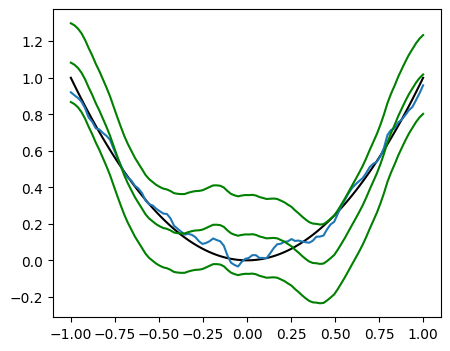

In [68]:
algorithm = gp.Iter_GP(X, Y, noise_level, cg_actions, kernel = gaussian_kernel)
algorithm.iter_forward(4)

approx_posterior_mean = algorithm.approx_posterior_mean(X)
true_posterior_mean = algorithm.kernel_matrix @ np.linalg.inv(algorithm.augmented_kernel_matrix) @ Y

variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    variance_vector = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

upper_ci = approx_posterior_mean + 2 * np.sqrt(variance_vector)
lower_ci = approx_posterior_mean - 2 * np.sqrt(variance_vector)

fig = plt.figure(figsize = (5, 4))
# plt.scatter(X[:, 0], Y)
plt.plot(X[:, 0], f, color = "black")
plt.plot(X[:, 0], true_posterior_mean)
plt.plot(X[:, 0], approx_posterior_mean, color = "green")
plt.plot(X[:, 0], upper_ci, color = "green")
plt.plot(X[:, 0], lower_ci, color = "green")

cg_mean = approx_posterior_mean

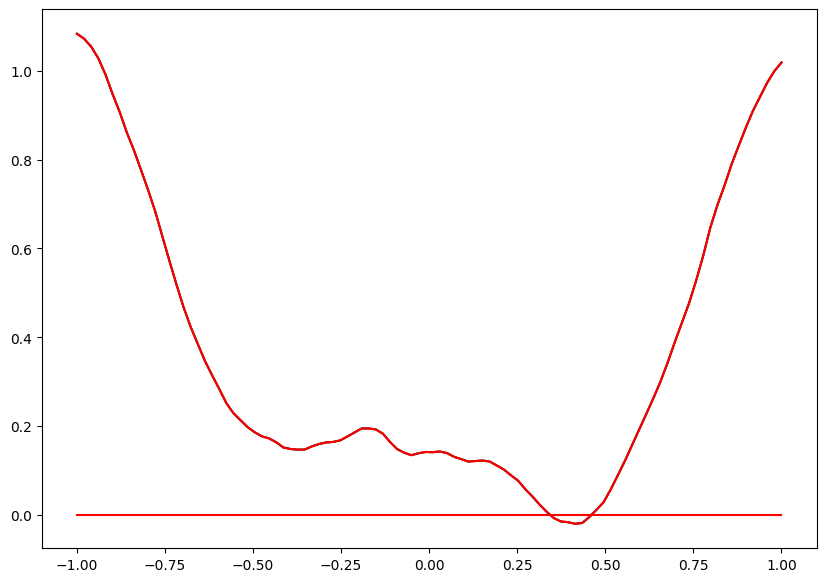

In [73]:
fig = plt.figure(figsize = (10, 7))
plt.plot(X[:, 0], cg_mean, color = "black")
plt.plot(X[:, 0], lanczos_mean, color = "red")
plt.plot(X[:, 0], lanczos_mean - cg_mean, color = "red")

We define standard orthonormal actions.

In [16]:
max_iter = 5
standard_actions = []
index = 0
for iter in range(0, max_iter):
    action = np.zeros(sample_size)
    action[index] = 1
    standard_actions.append(action)
    index = index + 1

/tmp/ipykernel_353128/1398572484.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_matrix[i, j] = kernel(X[i, :], X[j, :])


/tmp/ipykernel_354813/2441387015.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_matrix[i, j] = kernel(X[i, :], X[j, :])


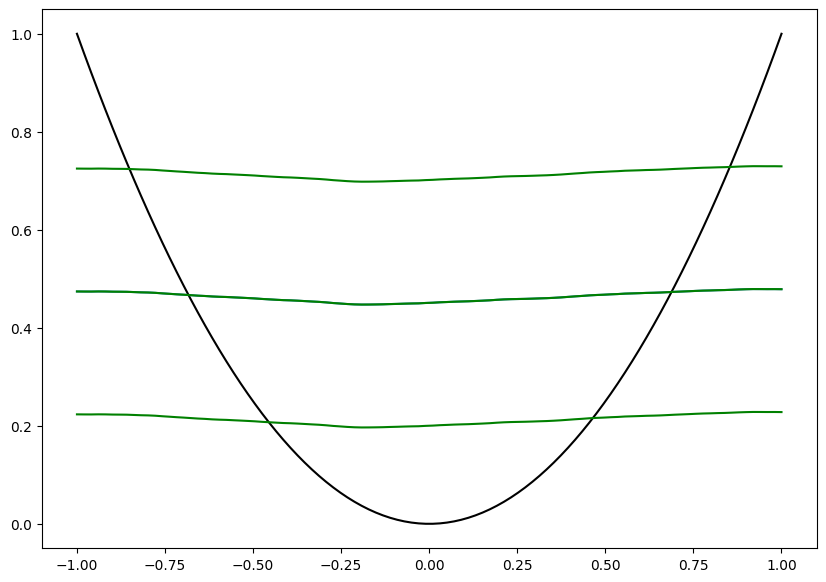

/tmp/ipykernel_353128/2362163050.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kernel_matrix[i, j] = kernel(X[i, :], X[j, :])


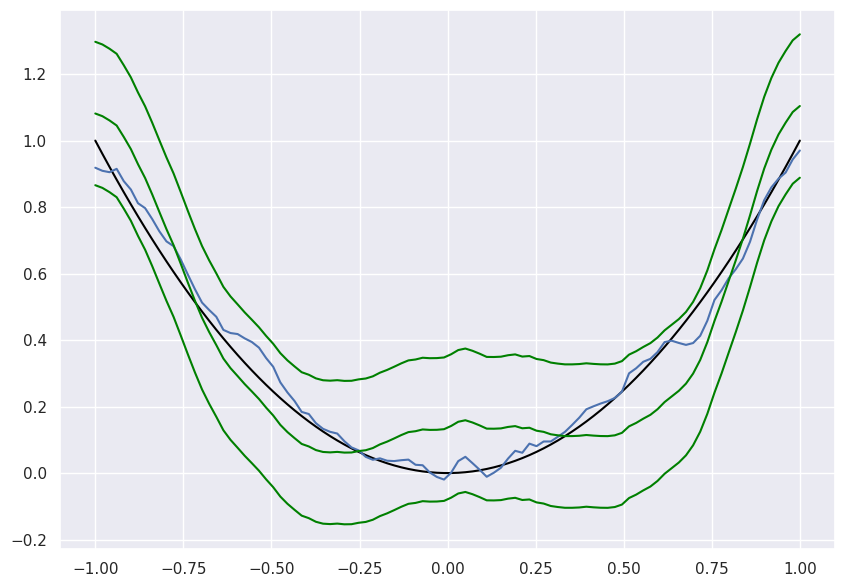

In [ ]:
kernel = gaussian_kernel
kernel_matrix = np.zeros((sample_size, sample_size)) 
for i in range(0, sample_size):
    for j in range(0, sample_size):
        kernel_matrix[i, j] = kernel(X[i, :], X[j, :])

engine = pylanczos.PyLanczos(kernel_matrix, True, 10)
lanczos_eigenvalues, lanczos_eigenvectors = engine.run()

lanczos_actions = []
index = 0
for iter in range(0, 5):
    action = lanczos_eigenvectors[:, index]
    lanczos_actions.append(action)
    index = index + 1

We define conjugate gradient actions

The approximate posterior mean based on the eigenvector actions works well.

In [ ]:
algorithm = gp.Iter_GP(X, Y, noise_level, eigenvector_actions, kernel = gaussian_kernel)
algorithm.iter_forward(10)

approx_posterior_mean = algorithm.approx_posterior_mean(X)
true_posterior_mean = algorithm.kernel_matrix @ np.linalg.inv(algorithm.augmented_kernel_matrix) @ Y

variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    variance_vector = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

upper_ci = approx_posterior_mean + 2 * np.sqrt(variance_vector)
lower_ci = approx_posterior_mean - 2 * np.sqrt(variance_vector)

fig = plt.figure(figsize = (10,7))
# plt.scatter(X[:, 0], Y)
plt.plot(X[:, 0], f, color = "black")
plt.plot(X[:, 0], true_posterior_mean)
plt.plot(X[:, 0], approx_posterior_mean, color = "green")
plt.plot(X[:, 0], upper_ci, color = "green")
plt.plot(X[:, 0], lower_ci, color = "green")

The standard actions work substancially worse. 

In [ ]:
algorithm = gp.Iter_GP(X, Y, noise_level, standard_actions, kernel = gaussian_kernel)
algorithm.iter_forward(10)

approx_posterior_mean = algorithm.approx_posterior_mean(X)
true_posterior_mean = algorithm.kernel_matrix @ np.linalg.inv(algorithm.augmented_kernel_matrix) @ Y

variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    variance_vector = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

upper_ci = approx_posterior_mean + 2 * np.sqrt(variance_vector)
lower_ci = approx_posterior_mean - 2 * np.sqrt(variance_vector)

fig = plt.figure(figsize = (10,7))
# plt.scatter(X[:, 0], Y)
plt.plot(X[:, 0], f, color = "black")
plt.plot(X[:, 0], true_posterior_mean, color = "red")
plt.plot(X[:, 0], approx_posterior_mean, color = "green")
plt.plot(X[:, 0], upper_ci, color = "green")
plt.plot(X[:, 0], lower_ci, color = "green")

However, the for the full iteration number, also the standard actions recover the true posterior. This is indicative of the fact that in order to contraction for the approximate posterior, the choice of the actions truly matters.

In [ ]:
algorithm = gp.Iter_GP(X, Y, noise_level, standard_actions, kernel = gaussian_kernel)
algorithm.iter_forward(100)

approx_posterior_mean = algorithm.approx_posterior_mean(X)
true_posterior_mean = algorithm.kernel_matrix @ np.linalg.inv(algorithm.augmented_kernel_matrix) @ Y

variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    variance_vector = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

upper_ci = approx_posterior_mean + 2 * np.sqrt(variance_vector)
lower_ci = approx_posterior_mean - 2 * np.sqrt(variance_vector)

fig = plt.figure(figsize = (10,7))
# plt.scatter(X[:, 0], Y)
plt.plot(X[:, 0], f, color = "black")
plt.plot(X[:, 0], true_posterior_mean, color = "red")
plt.plot(X[:, 0], approx_posterior_mean, color = "green")
plt.plot(X[:, 0], upper_ci, color = "green")
plt.plot(X[:, 0], lower_ci, color = "green")

We can  also use eigenvectors based on the Lanczos(?) algorithm directly.

In [ ]:
algorithm = gp.Iter_GP(X, Y, noise_level, lanczos_actions, kernel = gaussian_kernel)
algorithm.iter_forward(10)

approx_posterior_mean = algorithm.approx_posterior_mean(X)
true_posterior_mean = algorithm.kernel_matrix @ np.linalg.inv(algorithm.augmented_kernel_matrix) @ Y

variance_vector = np.zeros(sample_size)
for i in range(sample_size):
    variance_vector = algorithm.approx_posterior_covariance(X[i, :], X[i, :])

upper_ci = approx_posterior_mean + 2 * np.sqrt(variance_vector)
lower_ci = approx_posterior_mean - 2 * np.sqrt(variance_vector)

fig = plt.figure(figsize = (10,7))
# plt.scatter(X[:, 0], Y)
plt.plot(X[:, 0], f, color = "black")
plt.plot(X[:, 0], true_posterior_mean)
plt.plot(X[:, 0], approx_posterior_mean, color = "green")
plt.plot(X[:, 0], upper_ci, color = "green")
plt.plot(X[:, 0], lower_ci, color = "green")

In [ ]:
arr = np.array([1, 2, 3, 4, 5, 6, 7])

print(arr[0:])

Math in markdown? $a + b = \int f dx$